# Data Preprocessing

In [2]:
import numpy as np  # Need numpy 1.23.1
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
import itertools
import time
import json

from sklearn.cluster import DBSCAN
from scipy.stats import zscore
from scipy.optimize import minimize
from scipy.stats import uniform, randint
from shaphypetune import BoostSearch, BoostRFE, BoostRFA, BoostBoruta
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.metrics import accuracy_score, mean_squared_error
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import SelectFromModel
from sklearn.decomposition import PCA
from sklearn.feature_selection import RFE
from sklearn.datasets import make_classification, make_regression
import xgboost as xgb
from xgboost import XGBRegressor
from hyperopt import hp
from hyperopt import Trials
from lightgbm import *
import shap

import warnings
warnings.filterwarnings("ignore")

IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html


In [6]:
# Load dataset

train_df = pd.read_csv('./Data/train_final.csv')
train_df.shape

(201917, 2841)

In [7]:
# Fix datetime columns to be relative floating points

object_cols = train_df.select_dtypes(include=['O']).columns
ref = datetime(2017, 1, 1)

for col in object_cols:
    if 'latest' in col or 'earliest' in col:
        train_df[col] = (pd.to_datetime(train_df[col]) - ref).dt.total_seconds() / 3600.0

# Remove remaining features of type Object

train_df = train_df.drop(columns=train_df.select_dtypes(include=['O']).columns)

In [8]:
# Round all floats to 3 decimal places

for col in train_df.columns:
    if train_df[col].dtype in ['float', 'float32', 'float64'] and col != 'target':
        train_df[col] = train_df[col].round(3)

# Reduce memory size

for col in train_df.columns:
    if col == 'target':
        continue
    elif train_df[col].dtype == 'float64':
        max_float32 = train_df[col].astype('float32').max()
        min_float32 = train_df[col].astype('float32').min()
        if (train_df[col].max() == max_float32) and (train_df[col].min() == min_float32):
            train_df[col] = train_df[col].astype('float32')
    elif train_df[col].dtype == 'int64':
        max_int32 = train_df[col].astype('int32').max()
        min_int32 = train_df[col].astype('int32').min()
        if (train_df[col].max() == max_int32) and (train_df[col].min() == min_int32):
            train_df[col] = train_df[col].astype('int32')


In [9]:
# Replace numeric outliers with NaN in the dataset

numeric_columns = train_df.select_dtypes(include=np.number).drop(columns=['target'])
outliers_removed = 0

for column in numeric_columns.columns:
    na_mask = ~np.isnan(train_df[column])
    z_scores = np.abs(zscore(train_df[column][na_mask]))
    
    outliers_mask = (z_scores >= 3)
    outliers_removed += np.sum(outliers_mask)
    
    train_df.loc[na_mask, column] = np.where(outliers_mask, np.nan, train_df[column][na_mask])

print(f"Outliers reverted to NaN: {(outliers_removed/(train_df.shape[0]*train_df.shape[1])*100).round(3)}% of dataset")


Outliers reverted to NaN: 0.945% of dataset


In [10]:
# Check memory usage

train_df.info(memory_usage='deep')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 201917 entries, 0 to 201916
Columns: 2815 entries, feature_1 to subsector_max_spent
dtypes: bool(15), float32(1885), float64(860), int32(55)
memory usage: 2.8 GB


In [11]:
# Split and scale the data

X_dev_df, X_test_df, y_dev, y_test = train_test_split(
    train_df.drop(['target'], axis=1), train_df['target'], test_size=0.2, shuffle=True, random_state=42
)

X_columns = X_dev_df.columns

scaler = StandardScaler()
X_dev = scaler.fit_transform(X_dev_df)
X_test = scaler.transform(X_test_df)

## Feature Selection with RFE

In [12]:
# Feature Selection XGB

xgb_selector = BoostRFE(
    XGBRegressor(n_estimators=150, random_state=0, verbosity=0, n_jobs=-1, tree_method='gpu_hist'),
    min_features_to_select=100, step=50,
    importance_type='shap_importances', train_importance=False
)

xgb_selector.fit(X_dev, y_dev, eval_set=[(X_test, y_test)], early_stopping_rounds=6, verbose=0, eval_metric='rmse')

BoostRFE(estimator=XGBRegressor(base_score=None, booster=None, callbacks=None,
                                colsample_bylevel=None, colsample_bynode=None,
                                colsample_bytree=None, device=None,
                                early_stopping_rounds=None,
                                enable_categorical=False, eval_metric=None,
                                feature_types=None, gamma=None,
                                grow_policy=None, importance_type=None,
                                interaction_constraints=None,
                                learning_rate=None, max_bin=None,
                                max_cat_threshold=None, max_cat_to_onehot=None,
                                max_delta_step=None, max_depth=None,
                                max_leaves=None, min_child_weight=None,
                                missing=nan, monotone_constraints=None,
                                multi_strategy=None, n_estimators=150,
                                n_jobs=-1, num_parallel_tree=None,
                                random_state=0, ...),
         importance_type='shap_importances', min_features_to_select=100,
         step=50, train_importance=False)

In [13]:
# Feature Selection LGBM

lgbm_selector = BoostRFE(
    LGBMRegressor(n_estimators=150, random_state=0, verbosity=0, n_jobs=-1, tree_method='gpu_hist'),
    min_features_to_select=100, step=50,
    importance_type='shap_importances', train_importance=False
)

lgbm_selector.fit(X_dev, y_dev, eval_set=[(X_test, y_test)], eval_metric='rmse')

BoostRFE(estimator=LGBMRegressor(n_estimators=150, n_jobs=-1, random_state=0,
                                 tree_method='gpu_hist', verbosity=0),
         importance_type='shap_importances', min_features_to_select=100,
         step=50, train_importance=False)

In [15]:
# Save selectors, feature names and importances

xgb_selector.estimator_.save_model("./models/xgb_selector.json")
lgbm_selector.estimator_.booster_.save_model("./models/lgbm_selector.txt")

xgb_features, xgb_importances = [X_columns[xgb_selector.support_].to_list(), xgb_selector.estimator_.feature_importances_.tolist()]
lgbm_features, lgbm_importances = [X_columns[lgbm_selector.support_].to_list(), lgbm_selector.estimator_.feature_importances_.tolist()]

with open('./models/selector_features.txt', 'w') as file:
    json.dump({
        'xgb': [xgb_features, xgb_importances],
        'lgbm': [lgbm_features, lgbm_importances]
    }, file)

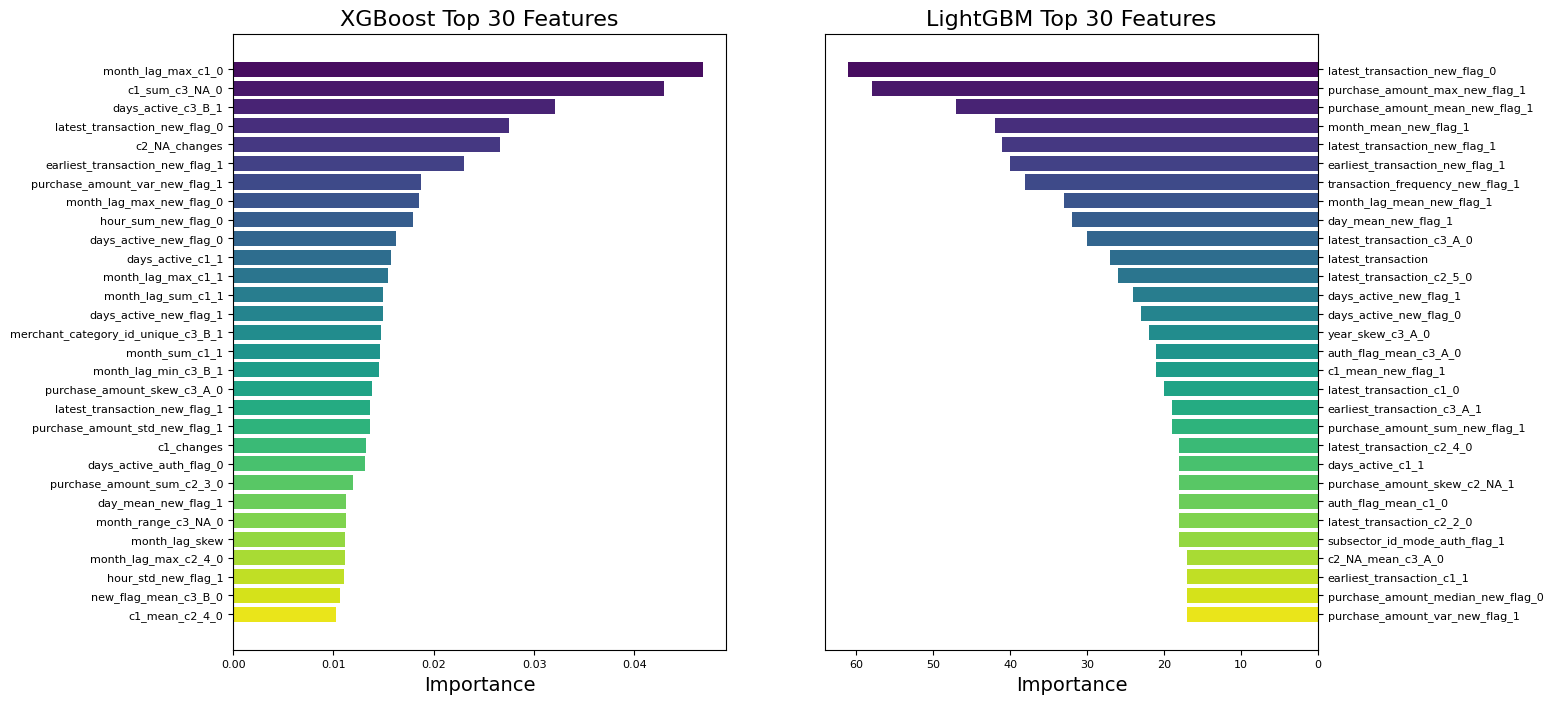

In [16]:
# Visualize feature importances for both models

show_features = 30

xgb_feature_importances = pd.DataFrame({'feature': xgb_features, 'importance': xgb_importances}).sort_values(by='importance', ascending=False)
lgbm_feature_importances = pd.DataFrame({'feature': lgbm_features, 'importance': lgbm_importances}).sort_values(by='importance', ascending=False)

fig, axs = plt.subplots(1, 2, figsize=(14, 8))

# XGBoost features

axs[0].barh(
    xgb_feature_importances['feature'][:show_features],
    xgb_feature_importances['importance'][:show_features],
    color=sns.color_palette("viridis", show_features)
)
axs[0].set_xlabel('Importance', fontsize=14)
axs[0].set_title(f'XGBoost Top {show_features} Features', fontsize=16)
axs[0].tick_params(axis='both', which='major', labelsize=8)
axs[0].invert_yaxis()

# LightGBM features

axs[1].barh(
    lgbm_feature_importances['feature'][:show_features],
    lgbm_feature_importances['importance'][:show_features],
    color=sns.color_palette("viridis", show_features)
)
axs[1].set_xlabel('Importance', fontsize=14)
axs[1].set_title(f'LightGBM Top {show_features} Features', fontsize=16)
axs[1].tick_params(axis='both', which='major', labelsize=8)
axs[1].yaxis.set_label_position("right")
axs[1].yaxis.tick_right()
axs[1].invert_yaxis()
axs[1].invert_xaxis()

plt.show()

## Bayesian Hyperparameter Tuning

In [35]:
# Split initial dataframe based on selected feature sets

feature_count = 100

xgb_top_features= xgb_feature_importances.head(feature_count)['feature'].tolist()
lgbm_top_features = lgbm_feature_importances.head(feature_count)['feature'].tolist()

xgb_split = train_test_split(
    train_df[xgb_top_features], train_df['target'], 
    test_size=0.2, shuffle=True, random_state=43
)

lgbm_split = train_test_split(
    train_df[lgbm_top_features], train_df['target'], 
    test_size=0.2, shuffle=True, random_state=43
)

xgb_split = { 'X_dev': xgb_split[0], 'X_test': xgb_split[1], 'y_dev': xgb_split[2], 'y_test': xgb_split[3] }
lgbm_split = { 'X_dev': lgbm_split[0], 'X_test': lgbm_split[1], 'y_dev': lgbm_split[2], 'y_test': lgbm_split[3] }

# Scale independently for each split

scaler_xgb = StandardScaler()
scaler_lgbm = StandardScaler()

xgb_split['X_dev'] = pd.DataFrame(scaler_xgb.fit_transform(xgb_split['X_dev']), columns=xgb_split['X_dev'].columns)
xgb_split['X_test'] = pd.DataFrame(scaler_xgb.transform(xgb_split['X_test']), columns=xgb_split['X_test'].columns)

lgbm_split['X_dev'] = pd.DataFrame(scaler_lgbm.fit_transform(lgbm_split['X_dev']), columns=lgbm_split['X_dev'].columns)
lgbm_split['X_test'] = pd.DataFrame(scaler_lgbm.transform(lgbm_split['X_test']), columns=lgbm_split['X_test'].columns)


In [270]:
# Tune the XGB model

xgb_hyperopt = {
    'learning_rate': hp.loguniform('learning_rate', -5, 0),
    'n_estimators': hp.randint("n_estimators", 5, 300),
    'max_depth': hp.randint("max_depth", 3, 15),
    'gamma': hp.uniform('gamma', 0, 5),
    'reg_alpha': hp.uniform('reg_alpha', 0, 200),
    'reg_lambda': hp.uniform('reg_lambda', 0, 2),
    'colsample_bytree': hp.uniform('colsample_bytree', 0.5, 1),
    'min_child_weight': hp.uniform('min_child_weight', 0, 10),
    'subsample': hp.uniform('subsample', 0.5, 1), 
    'scale_pos_weight': hp.uniform('scale_pos_weight', 0, 5), 
    'max_delta_step': hp.uniform('max_delta_step', 0, 5), 
    'colsample_bylevel': hp.uniform('colsample_bylevel', 0.5, 1),
    'colsample_bynode': hp.uniform('colsample_bynode', 0.5, 1),
}

xgb_model = BoostSearch(
    XGBRegressor(n_jobs=-1, tree_method='gpu_hist'), 
    param_grid=xgb_hyperopt, n_iter=500, sampling_seed=44
)

xgb_model.fit(
    xgb_split['X_dev'], xgb_split['y_dev'], trials=Trials(), 
    eval_set=[(xgb_split['X_test'], xgb_split['y_test'])], 
    early_stopping_rounds=6, verbose=0, eval_metric='rmse'
)


500 trials detected for ('learning_rate', 'n_estimators', 'max_depth', 'gamma', 'reg_alpha', 'reg_lambda', 'colsample_bytree', 'min_child_weight', 'subsample', 'scale_pos_weight', 'max_delta_step', 'colsample_bylevel', 'colsample_bynode')

trial: 0001 ### iterations: 00006 ### eval_score: 3.89743
trial: 0002 ### iterations: 00102 ### eval_score: 3.71804
trial: 0003 ### iterations: 00153 ### eval_score: 3.71858
trial: 0004 ### iterations: 00070 ### eval_score: 3.7208
trial: 0005 ### iterations: 00012 ### eval_score: 3.74607
trial: 0006 ### iterations: 00018 ### eval_score: 3.7361
trial: 0007 ### iterations: 00000 ### eval_score: 3.80031
trial: 0008 ### iterations: 00004 ### eval_score: 3.8135
trial: 0009 ### iterations: 00003 ### eval_score: 3.78937
trial: 0010 ### iterations: 00041 ### eval_score: 3.72137
trial: 0011 ### iterations: 00054 ### eval_score: 3.72419
trial: 0012 ### iterations: 00219 ### eval_score: 3.71396
trial: 0013 ### iterations: 00027 ### eval_score: 3.73134
trial: 0

BoostSearch(estimator=XGBRegressor(base_score=None, booster=None,
                                   callbacks=None, colsample_bylevel=None,
                                   colsample_bynode=None, colsample_bytree=None,
                                   device=None, early_stopping_rounds=None,
                                   enable_categorical=False, eval_metric=None,
                                   feature_types=None, gamma=None,
                                   grow_policy=None, importance_type=None,
                                   interaction_constraints=None,
                                   learning_rate=None, max_bin...
                        'n_estimators': <hyperopt.pyll.base.Apply object at 0x000001CEA716C810>,
                        'reg_alpha': <hyperopt.pyll.base.Apply object at 0x000001CFF67B3E90>,
                        'reg_lambda': <hyperopt.pyll.base.Apply object at 0x000001CFF2848410>,
                        'scale_pos_weight': <hyperopt.pyll.base.Apply object at 0x000001CFFE64B690>,
                        'subsample': <hyperopt.pyll.base.Apply object at 0x000001CE8B94BED0>},
            sampling_seed=44)

In [271]:
# XGB model information

print('XGB Best score: ', xgb_model.best_score_)
print('Params:', xgb_model.best_params_)

XGB Best score:  3.7021132426564756
Params: {'colsample_bylevel': 0.6633478280595972, 'colsample_bynode': 0.7413900223133505, 'colsample_bytree': 0.626700972997318, 'gamma': 0.517163249848182, 'learning_rate': 0.0706309653833262, 'max_delta_step': 3.4840395324012703, 'max_depth': 8, 'min_child_weight': 8.183940877339175, 'n_estimators': 253, 'reg_alpha': 122.82544531759522, 'reg_lambda': 0.3443831994542931, 'scale_pos_weight': 0.8255551461240965, 'subsample': 0.9969979842740919}


In [298]:
# Tune the LGBM model

lgbm_hyperopt = {
    'learning_rate': hp.loguniform('learning_rate', -5, 0),
    'n_estimators': hp.randint("n_estimators", 5, 300),
    'max_depth': hp.randint("max_depth", 3, 15),
    'num_leaves': hp.randint('num_leaves', 8, 128),
    'reg_alpha': hp.uniform('reg_alpha', 0, 200),
    'reg_lambda': hp.uniform('reg_lambda', 0, 2),
    'colsample_bytree': hp.uniform('colsample_bytree', 0.5, 1),
    'min_child_weight': hp.uniform('min_child_weight', 0, 10),
    'subsample': hp.uniform('subsample', 0.5, 1), 
    'scale_pos_weight': hp.uniform('scale_pos_weight', 0, 5), 
    'max_delta_step': hp.uniform('max_delta_step', 0, 5), 
    'colsample_bynode': hp.uniform('colsample_bynode', 0.5, 1),
    'boosting_type': hp.choice('boosting_type', ['gbdt', 'dart', 'goss']),
    # 'bagging_fraction': hp.uniform('bagging_fraction', 0.5, 1),
    # 'feature_fraction': hp.uniform('feature_fraction', 0.5, 1),
    # 'bagging_freq': hp.randint('bagging_freq', 1, 11),
    'min_child_samples': hp.randint('min_child_samples', 5, 100),
    'min_split_gain': hp.uniform('min_split_gain', 0, 1),
    'cat_smooth': hp.uniform('cat_smooth', 1, 20),
}

lgbm_model = BoostSearch(
    LGBMRegressor(n_jobs=-1),
    param_grid=lgbm_hyperopt, n_iter=500, sampling_seed=47
)

lgbm_model.fit(
    lgbm_split['X_dev'], lgbm_split['y_dev'], trials=Trials(), 
    eval_set=[(lgbm_split['X_test'], lgbm_split['y_test'])], 
    eval_metric='rmse'
)


500 trials detected for ('learning_rate', 'n_estimators', 'max_depth', 'num_leaves', 'reg_alpha', 'reg_lambda', 'colsample_bytree', 'min_child_weight', 'subsample', 'scale_pos_weight', 'max_delta_step', 'colsample_bynode', 'boosting_type', 'min_child_samples', 'min_split_gain', 'cat_smooth')

trial: 0001 ### iterations: 00000 ### eval_score: 14.17353
trial: 0002 ### iterations: 00000 ### eval_score: 13.90953
trial: 0003 ### iterations: 00000 ### eval_score: 14.10064
trial: 0004 ### iterations: 00000 ### eval_score: 13.86063
trial: 0005 ### iterations: 00000 ### eval_score: 14.72779
trial: 0006 ### iterations: 00000 ### eval_score: 18.12789
trial: 0007 ### iterations: 00000 ### eval_score: 13.83583
trial: 0008 ### iterations: 00000 ### eval_score: 14.21482
trial: 0009 ### iterations: 00000 ### eval_score: 13.89512
trial: 0010 ### iterations: 00000 ### eval_score: 14.39713
trial: 0011 ### iterations: 00000 ### eval_score: 14.29892
trial: 0012 ### iterations: 00000 ### eval_score: 14.084

BoostSearch(estimator=LGBMRegressor(n_jobs=-1), n_iter=500,
            param_grid={'boosting_type': <hyperopt.pyll.base.Apply object at 0x000001D0015E88D0>,
                        'cat_smooth': <hyperopt.pyll.base.Apply object at 0x000001CFE0E73350>,
                        'colsample_bynode': <hyperopt.pyll.base.Apply object at 0x000001CEA854D150>,
                        'colsample_bytree': <hyperopt.pyll.base.Apply object at 0x000001CE930ECC10>,
                        '...
                        'num_leaves': <hyperopt.pyll.base.Apply object at 0x000001CE8451E310>,
                        'reg_alpha': <hyperopt.pyll.base.Apply object at 0x000001CE671C67D0>,
                        'reg_lambda': <hyperopt.pyll.base.Apply object at 0x000001CFE4BE8410>,
                        'scale_pos_weight': <hyperopt.pyll.base.Apply object at 0x000001CEA779A810>,
                        'subsample': <hyperopt.pyll.base.Apply object at 0x000001CE3FDD0410>},
            sampling_seed=47)

In [299]:
# LGBM model information

print('LGBM Best score: ', lgbm_model.best_score_, np.sqrt(lgbm_model.best_score_))
print('Params:', lgbm_model.best_params_)

LGBM Best score:  13.781984394290449 3.7124095132798116
Params: {'boosting_type': 'goss', 'cat_smooth': 19.46865298717783, 'colsample_bynode': 0.9963830107410088, 'colsample_bytree': 0.820002871903411, 'learning_rate': 0.04921901604326581, 'max_delta_step': 3.7527935857199606, 'max_depth': 8, 'min_child_samples': 30, 'min_child_weight': 5.50525048231899, 'min_split_gain': 0.9059640342873664, 'n_estimators': 286, 'num_leaves': 30, 'reg_alpha': 136.4556844446849, 'reg_lambda': 1.3514308363156684, 'scale_pos_weight': 0.47845880752506864, 'subsample': 0.6457988228919561}


# Submission

In [22]:
# Import the test dataset

kaggle_df = pd.read_csv('./Data/test_final.csv')

# Fix datetime columns to be relative floating points

object_cols = kaggle_df.select_dtypes(include=['O']).columns
ids = kaggle_df['card_id']
ref = datetime(2017, 1, 1)

for col in object_cols:
    if 'latest' in col or 'earliest' in col:
        kaggle_df[col] = (pd.to_datetime(kaggle_df[col]) - ref).dt.total_seconds() / 3600.0

# Remove remaining features of type Object

kaggle_df = kaggle_df.drop(columns=kaggle_df.select_dtypes(include=['O']).columns)

# Round all floats to 3 decimal places

for col in kaggle_df.columns:
    if kaggle_df[col].dtype in ['float', 'float32', 'float64'] and col != 'target':
        kaggle_df[col] = kaggle_df[col].round(3)

# Reduce memory size

for col in kaggle_df.columns:
    if col == 'target':
        continue
    elif kaggle_df[col].dtype == 'float64':
        max_float32 = kaggle_df[col].astype('float32').max()
        min_float32 = kaggle_df[col].astype('float32').min()
        if (kaggle_df[col].max() == max_float32) and (kaggle_df[col].min() == min_float32):
            kaggle_df[col] = kaggle_df[col].astype('float32')
    elif kaggle_df[col].dtype == 'int64':
        max_int32 = kaggle_df[col].astype('int32').max()
        min_int32 = kaggle_df[col].astype('int32').min()
        if (kaggle_df[col].max() == max_int32) and (kaggle_df[col].min() == min_int32):
            kaggle_df[col] = kaggle_df[col].astype('int32')

# Scale versions for each model -- no target variable, can scale entire dataframe

kaggle_xgb = scaler_xgb.transform(kaggle_df[xgb_top_features])
kaggle_lgbm = scaler_lgbm.transform(kaggle_df[lgbm_top_features])

In [20]:
# Define function that saves predictions

def submit(model, X_test):

    pred = None
    try:
        pred = model.predict(X_test).tolist()
    except:
        pred = model

    submission = pd.DataFrame({
        'card_id': ids,
        'target': pred
    })
    submission.to_csv('./Data/submission.csv', index=None)

# Define a function for saving model versions

def save_model(model, name, description, params, features):
    try:
        model.save_model(f"./models/{name}.json")
    except:
        model.booster_.save_model(f"./models/{name}.json")

    features_dict = None
    with open('./models/model_features.txt', 'r') as file:
        features_dict = json.loads(file.read())
    features_dict[name] = [description, params, features]

    with open('./models/model_features.txt', 'w') as file:
        json.dump(features_dict, file)

# Define a function to optimize model combinations

def optimal_combination(y_test, predictions, method):

    pred_matrix = np.vstack(predictions)

    def objective(weights, pred_matrix, y_test):
        pred_combination = np.dot(weights, pred_matrix)
        rmse = np.sqrt(mean_squared_error(y_test, pred_combination))
        return rmse

    constraint = ({'type': 'eq', 'fun': lambda w: 1 - sum(w)})
    initial_weights = np.ones(len(predictions))/len(predictions)
    bounds = [(0, 1) for _ in range(len(predictions))]

    if method:

        optimal_weights = minimize(objective, initial_weights, args=(pred_matrix, y_test), method=method, constraints=constraint, bounds=bounds).x
        pred_optimal = np.dot(optimal_weights, pred_matrix)
        rmse = np.sqrt(mean_squared_error(y_test, pred_optimal))
    
        return optimal_weights, pred_optimal, rmse
    
    else:

        methods = ['SLSQP', 'Nelder-Mead', 'Powell', 'L-BFGS-B']

        best_method, optimal_weights, pred_optimal, rmse = None, None, None, np.inf

        for m in methods:

            w = minimize(objective, initial_weights, args=(pred_matrix, y_test), method=m, constraints=constraint, bounds=bounds).x
            p = np.dot(w, pred_matrix)
            r = np.sqrt(mean_squared_error(y_test, p))

            if r < rmse:

                best_method, optimal_weights, pred_optimal, rmse = m, w, p, r

        return optimal_weights, pred_optimal, [best_method, rmse]


In [27]:
# Submit an individual model's predictions (leave one commented)

submit(xgb_model.estimator_, kaggle_xgb)
#submit(lgbm_model.estimator_, kaggle_lgbm)

In [243]:
# Find best combination of models

# Both xgb_split and lgbm_split have the same y_test because we used a uniform random_seed
# If you need convincing, run the following line:
# xgb_split['y_test'].equals(lgbm_split['y_test'])

xgb_pred = xgb_model.predict(xgb_split['X_test'])
lgbm_pred = lgbm_model.predict(lgbm_split['X_test'])

weights, pred, rmse = optimal_combination(xgb_split['y_test'], [xgb_pred, lgbm_pred], 'SLSQP')
print("Weights:", weights, "\tRMSE:", rmse)

xgb_kaggle_pred = xgb_model.predict(kaggle_xgb)
lgbm_kaggle_pred = lgbm_model.predict(kaggle_lgbm)

pred_weighted = np.dot(weights, [xgb_kaggle_pred, lgbm_kaggle_pred])
submit(pred_weighted, None)

In [300]:
# Save the current models

save_model(xgb_model.estimator_, 'xgb', '', list(xgb_model.best_params_), xgb_top_features)
save_model(lgbm_model.estimator_, 'lgbm', '', list(lgbm_model.best_params_), lgbm_top_features)

# Extra Testing

In [38]:
# Combining models

xgb_xgb, xgb_xgb_500, xgb_lgbm = XGBRegressor(), XGBRegressor(), XGBRegressor()
xgb_xgb.load_model('./models/xgb_xgb.json')
# xgb_xgb_500.load_model('./models/xgb_xgb_500.json')
xgb_lgbm.load_model('./models/xgb_lgbm.json')
lgbm_xgb = Booster(model_file='./models/lgbm_xgb.json')
# lgbm_xgb_1000 = Booster(model_file='./models/lgbm_xgb_1000.json')
# lgbm_xgb_1000_new_param = Booster(model_file='./models/lgbm_xgb_1000_new_param.json')
lgbm_lgbm = Booster(model_file='./models/lgbm_lgbm.json')
# lgbm_lgbm_500 = Booster(model_file='./models/lgbm_lgbm_500.json')

model_names = ['xx', 'xx500', 'xl', 'lx', 'lx1000', 'lx1000new', 'll', 'll500']

predictions = [
    xgb_xgb.predict(xgb_split['X_test']),
    # xgb_xgb_500.predict(xgb_split['X_test']),
    xgb_lgbm.predict(lgbm_split['X_test']),
    lgbm_xgb.predict(xgb_split['X_test']),
    # lgbm_xgb_1000.predict(xgb_split['X_test']),
    # lgbm_xgb_1000_new_param.predict(xgb_split['X_test']),
    lgbm_lgbm.predict(lgbm_split['X_test']),
    # lgbm_lgbm_500.predict(lgbm_split['X_test'])
]

# method options: 'SLSQP', 'Nelder-Mead', 'Powell', 'L-BFGS-B' --> None tests them all
weights, pred, rmse = optimal_combination(xgb_split['y_test'], predictions, None)
print("Weights:", weights.round(3), "\nRMSE:", rmse)

kaggle_predictions = [
    xgb_xgb.predict(kaggle_xgb),
    # xgb_xgb_500.predict(kaggle_xgb),
    xgb_lgbm.predict(kaggle_lgbm),
    lgbm_xgb.predict(kaggle_xgb),
    # lgbm_xgb_1000.predict(kaggle_xgb),
    # lgbm_xgb_1000_new_param.predict(kaggle_xgb),
    lgbm_lgbm.predict(kaggle_lgbm),
    # lgbm_lgbm_500.predict(kaggle_lgbm),
]

# Best score so far : 3.63636, 3.71332 : xgb_xgb, xgb_lgbm, lgbm_xgb, and lgbm_lgmb

pred_weighted = np.dot(weights, kaggle_predictions)
submit(pred_weighted, None)



Weights: [0.32  0.142 0.434 0.229] 
RMSE: ['Nelder-Mead', 3.698169485021603]


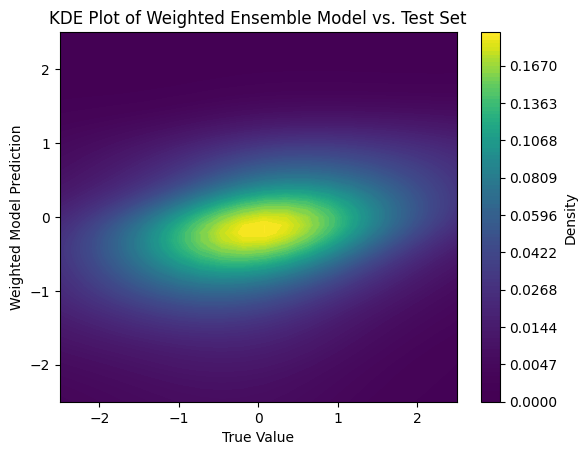

In [62]:
# KDE plot of weighted model vs personal test set

pred_test = np.dot([0.32, 0.142, 0.434, 0.229] , predictions)

sns.kdeplot(x=xgb_split['y_test'], y=pred_test, cmap="viridis", fill=True, thresh=0, levels=100, cbar=True, facecolor='black', cbar_kws={'label': 'Density'})

plt.xlabel('True Value')
plt.ylabel('Weighted Model Prediction')
plt.title('KDE Plot of Weighted Ensemble Model vs. Test Set')

plt.xlim(-2.5, 2.5)
plt.ylim(-2.5, 2.5)
plt.show()

In [277]:
# Test all combinations of existing models

combinations = list(itertools.product([0, 1], repeat=len(predictions)))
results_df = pd.DataFrame(columns=['Combination', 'Models', 'Method', 'RMSE', 'Weights', 'Predictions'])

for i, combination in enumerate(combinations):

    selected_predictions = [predictions[j] for j, include in enumerate(combination) if include]
    selected_names = [model_names[j] for j, include in enumerate(combination) if include]

    if selected_predictions == []: continue

    weights, pred, rmse = optimal_combination(xgb_split['y_test'], selected_predictions, None)

    results_df.loc[len(results_df.index)] = [selected_names, len(selected_names), rmse[0], rmse[1], weights, pred]

results_df = results_df.sort_values(by='RMSE', ascending=True)
results_df

,Combination,Models,Method,RMSE,Weights,Predictions
118,"[xx, xx500, xl, lx1000, lx1000new, ll]",6,Nelder-Mead,3.694393,"[8.942760437384238e-08, 0.36570271593824016, 0...","[-1.3302345825511772, -0.8353453913785946, -0...."
54,"[xx500, xl, lx1000, lx1000new, ll]",5,Nelder-Mead,3.694393,"[0.3656962121284777, 0.11105684700005677, 0.25...","[-1.3302619904007063, -0.8353716650646361, -0...."
62,"[xx500, xl, lx, lx1000, lx1000new, ll]",6,L-BFGS-B,3.694393,"[0.36565502708167374, 0.11106418033824648, 0.0...","[-1.3301972302591536, -0.8353717761261206, -0...."
126,"[xx, xx500, xl, lx, lx1000, lx1000new, ll]",7,Nelder-Mead,3.694393,"[7.044361118597387e-06, 0.3656727411525545, 0....","[-1.3305504026428112, -0.8352909598109968, -0...."
102,"[xx, xx500, lx1000, lx1000new, ll]",5,Nelder-Mead,3.694553,"[0.025284757229213917, 0.3779211886458506, 0.2...","[-1.3533925391150414, -0.7891361998143469, -0...."
...,...,...,...,...,...,...
7,[lx],1,SLSQP,3.704796,[1.0],"[-1.0100196049440857, -0.7301049120533722, -0...."
16,"[xl, ll]",2,L-BFGS-B,3.707682,"[0.556660781419919, 0.5521090352684814]","[-1.8905142316151684, -0.9387713399959754, -0...."
63,[xx],1,SLSQP,3.708576,[1.0],"[-1.142872929573059, -0.8451951146125793, -0.2..."
0,[ll],1,SLSQP,3.713935,[1.0],"[-2.056800832428025, -0.6112043736648574, -0.4..."


In [264]:
# Try training XGB on full dataset with good weights

xgb_full = XGBRegressor(**xgb_model.best_params_)
xgb_full.fit(
    np.concatenate([xgb_split['X_dev'], xgb_split['X_test']]),
    np.concatenate([xgb_split['y_dev'], xgb_split['y_test']])
)

submit(xgb_full, kaggle_xgb)

In [315]:
# Save predictions and y_test

test_pred_df = pd.DataFrame({
    'y_test': xgb_split['y_test'],
    'xgb_xgb': xgb_xgb.predict(xgb_split['X_test']),
    'xgb_xgb_500': xgb_xgb_500.predict(xgb_split['X_test']),
    'xgb_lgbm': xgb_lgbm.predict(lgbm_split['X_test']),
    'lgbm_xgb': lgbm_xgb.predict(xgb_split['X_test']),
    'lgbm_xgb_1000': lgbm_xgb_1000.predict(xgb_split['X_test']),
    'lgbm_xgb_1000_new_param': lgbm_xgb_1000_new_param.predict(xgb_split['X_test']),
    'lgbm_lgbm': lgbm_lgbm.predict(lgbm_split['X_test']),
    'lgbm_lgbm_500': lgbm_lgbm_500.predict(lgbm_split['X_test'])
})

kaggle_pred_df = pd.DataFrame({
    'xgb_xgb': xgb_xgb.predict(kaggle_xgb),
    'xgb_xgb_500': xgb_xgb_500.predict(kaggle_xgb),
    'xgb_lgbm': xgb_lgbm.predict(kaggle_lgbm),
    'lgbm_xgb': lgbm_xgb.predict(kaggle_xgb),
    'lgbm_xgb_1000': lgbm_xgb_1000.predict(kaggle_xgb),
    'lgbm_xgb_1000_new_param': lgbm_xgb_1000_new_param.predict(kaggle_xgb),
    'lgbm_lgbm': lgbm_lgbm.predict(kaggle_lgbm),
    'lgbm_lgbm_500': lgbm_lgbm_500.predict(kaggle_lgbm),
})

test_pred_df.to_csv('./Data/test_predictions.csv', index=None)
kaggle_pred_df.to_csv('./Data/kaggle_predictions.csv', index=None)